In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import os
import time
from mpl_toolkits.mplot3d import Axes3D 
import scipy

In [2]:
import gymnasium
from gymnasium import spaces

In [3]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import results_plotter
from skfem import *
from skfem.helpers import ddot, sym_grad, eye, trace
from skfem import MeshHex

In [4]:
x0, y0, z0 = 3, 3, 5

### Finite Element Model 

In [5]:
# def FEA_u(x0, y0, z0 , el, load = 10):
    
#     x = np.linspace(0, 1, x0) 
#     y = np.linspace(0, 1, y0)
#     z = np.linspace(0, 1, z0)

#     m = MeshHex.init_tensor(x, y, z).with_defaults()
 
#     e = ElementVector(ElementHex1())
#     basis = Basis(m, e, intorder=3)

#     num_nodes = m.p.shape[1]
#     E_nodal = np.zeros(num_nodes)

#     for i in range(m.p.shape[1]):
#         E_nodal[i] = el[i]

#     basis_s = basis.with_element(ElementHex1())
#     E_param = basis_s.interpolate(E_nodal)

#     # 4. Define Material Law with spatially varying E
#     nu = 0.3
#     @BilinearForm
#     def stiffness(u, v, w):
#         # 'w' carries the interpolated parameters
#         E_local = w['elastic_modulus']
#         lam = E_local * nu / ((1. + nu) * (1. - 2. * nu))
#         mu = E_local / (2. * (1. + nu))

#         def C(T):
#             return 2. * mu * T + lam * eye(trace(T), T.shape[0])

#         return ddot(C(sym_grad(u)), sym_grad(v))

#     K = stiffness.assemble(basis, elastic_modulus=E_param)

#     f = basis.zeros()
#     target_coords = np.array([1.0, 1.0, 1.0])
#     dists = np.linalg.norm(m.p.T - target_coords, axis=1)
#     node_idx = np.argmin(dists)
#     dof_idx = basis.nodal_dofs[2, node_idx] 
#     f[dof_idx] = load
#     u = solve(*condense(K, f, D=basis.get_dofs('front')))
#     compliance = f @ u
#     return u, compliance

In [6]:
def FEA_u(x0, y0, z0, el, load=10):

    # --------------------------------------------------
    # 1. Mesh
    # --------------------------------------------------
    x = np.linspace(0, 1, x0)
    y = np.linspace(0, 1, y0)
    z = np.linspace(0, 1, z0)

    m = MeshHex.init_tensor(x, y, z).with_defaults()

    e = ElementVector(ElementHex1())
    basis = Basis(m, e, intorder=3)

    # --------------------------------------------------
    # 2. Spatially varying elastic modulus
    # --------------------------------------------------
    num_nodes = m.p.shape[1]
    E_nodal = np.zeros(num_nodes)

    for i in range(num_nodes):
        E_nodal[i] = el[i]

    basis_s = basis.with_element(ElementHex1())
    E_param = basis_s.interpolate(E_nodal)

    # --------------------------------------------------
    # 3. Material law
    # --------------------------------------------------
    nu = 0.3

    @BilinearForm
    def stiffness(u, v, w):
        E_local = w['elastic_modulus']
        lam = E_local * nu / ((1. + nu) * (1. - 2. * nu))
        mu = E_local / (2. * (1. + nu))

        def C(T):
            return 2. * mu * T + lam * eye(trace(T), T.shape[0])

        return ddot(C(sym_grad(u)), sym_grad(v))

    K = stiffness.assemble(basis, elastic_modulus=E_param)

    # --------------------------------------------------
    # 4. Load 
    # --------------------------------------------------
    f = basis.zeros()
    coords = m.p.T
    tol = 1e-8
    
    edge_nodes = np.where(
        (np.abs(coords[:, 0] - 1.0) < tol) &
        (np.abs(coords[:, 2] - 1.0) < tol)
    )[0]

    # pick the two end nodes of the edge
    edge_nodes = edge_nodes[np.argsort(coords[edge_nodes, 1])]
    edge_nodes = np.array([edge_nodes[0], edge_nodes[-1]])

    # apply load in x-direction, split evenly
    for node in edge_nodes:
        dof = basis.nodal_dofs[0, node]
        f[dof] += load / 2.0

    # --------------------------------------------------
    # 5. Fix ONLY four corner nodes 
    # --------------------------------------------------
  
    front_nodes = np.where(np.abs(coords[:, 2] - 0.0) < tol)[0]

    # get x,y extremes
    x_vals = coords[front_nodes, 0]
    y_vals = coords[front_nodes, 1]
    x_min, x_max = x_vals.min(), x_vals.max()
    y_min, y_max = y_vals.min(), y_vals.max()

    # four corner nodes
    corner_nodes = front_nodes[
        (np.isclose(coords[front_nodes, 0], x_min, atol=tol) |
         np.isclose(coords[front_nodes, 0], x_max, atol=tol)) &
        (np.isclose(coords[front_nodes, 1], y_min, atol=tol) |
         np.isclose(coords[front_nodes, 1], y_max, atol=tol))
    ]

    assert len(corner_nodes) == 4, "Did not find exactly 4 corner nodes."

    # fix ALL displacement components at corners
    fixed_dofs = basis.nodal_dofs[:, corner_nodes].ravel()

    # --------------------------------------------------
    # 6. Solve
    # --------------------------------------------------
    u = solve(*condense(K, f, D=fixed_dofs))

    compliance = f @ u

    return u, compliance

### RL model

In [7]:
class Model:
    def __init__(self, x):
        self.flag_ = True
        self.n, self.m = x.shape
        self.actions_dic={} 
    
        k=0
        for i in range(self.n):
            for j in range(self.m):
                for t in range(1,3):
                    self.actions_dic[k]=(i,j,t)
                    k+=1

    def action_space_(self, action, X):
        x,y,t =self.actions_dic[action]
        X[x][y]=t        

In [8]:
def draw(topology):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.voxels(topology, edgecolor='k')
#     ax.invert_zaxis() 
    ax.view_init(elev=-10, azim=-45) 
    plt.show()

In [9]:
class CantileverEnv(gymnasium.Env):
    
    metadata = {"render.modes": ["human"]}

    def __init__(self,x1,y1):
        super().__init__()
        self.x0=x1
        self.y0=y1
        
        DIM =  self.x0 * self.y0
        N_DISCRETE_ACTIONS = self.x0 * self.y0 * 2
        
        self.action_space = spaces.Discrete(N_DISCRETE_ACTIONS)
        self.observation_space = spaces.Box(low=np.array([-1e10 for x in range(DIM)]),
                                            high=np.array([1e10 for y in range(DIM)]),
                                            shape=(DIM,),
                                           dtype=np.float64)
        
 
        self.x = np.zeros(( self.x0, self.y0))
    
        self.M=Model(self.x)
        
        self.reward=0
        self.step_=0
        self.needs_reset = True
        self.ext_reward=0

        
    def step(self, action):
        
        
        self.M.action_space_(action, self.x)        
        self.step_+=1
               
        done=False
                  
        if self.step_ > 2.5 * self.x0 * self.y0:
            done=True            
            
        if self.needs_reset:
            raise RuntimeError("Tried to step environment that needs reset")
            
        if done:
            self.needs_reset = True
                         
        
        return self.x.reshape(self.x.shape[0]*self.x.shape[1]), self.ext_reward, done, False, dict()

    def reset(self, seed=0):
                   
        self.x = np.zeros((self.x0, self.y0))

        self.reward=0
        self.needs_reset = False
        self.step_=0
        self.ext_reward=0

        return self.x.reshape(self.x.shape[0]*self.x.shape[1]),{}

    def render(self, mode="human"):
        pass   

    def close(self):
        pass

In [10]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """

    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, "best_model")
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            
            
            
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
#             print(y)
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                
                mean_reward = np.mean(y[-100:])
                
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}"
                    )

                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)

        return True

In [11]:
def reconstruct_3d_structure(xy_plane, yz_plane, xz_plane, ext_type=1.0, int_type=2.0):
    """
    Reconstructs a 3D structure from three 2D projections using extrusion and intersection.

    Parameters:
        xy_plane (ndarray): 2D binary array (X by Y) projection in XY plane.
        yz_plane (ndarray): 2D binary array (Y by Z) projection in YZ plane.
        xz_plane (ndarray): 2D binary array (X by Z) projection in XZ plane.

    Returns:
        volume (ndarray): 3D binary array (X by Y by Z) representing the reconstructed structure.
    """
    x_dim, y_dim = xy_plane.shape
    y_dim2, z_dim = yz_plane.shape
    x_dim2, z_dim2 = xz_plane.shape

    assert x_dim == x_dim2, "X dimensions mismatch between XY and XZ planes."
    assert y_dim == y_dim2, "Y dimensions mismatch between XY and YZ planes."
    assert z_dim == z_dim2, "Z dimensions mismatch between YZ and XZ planes."
        
    def get_volume(line_type):
        t_b = (xy_plane == line_type)
        f_b = (xz_plane == line_type)
        s_b = (yz_plane == line_type)
        
        # Broadcasting to create 3D intersection
        # Dimensions: [Y, X, Z] based on standard multiview projection
        return t_b[:, :, np.newaxis] & f_b[:, np.newaxis, :] & s_b[np.newaxis, :, :]
    
    def get_volume0():
        t_b = (xy_plane > 0)
        f_b = (xz_plane  > 0)
        s_b = (yz_plane > 0)
        
        # Broadcasting to create 3D intersection
        # Dimensions: [Y, X, Z] based on standard multiview projection
        return t_b[:, :, np.newaxis] & f_b[:, np.newaxis, :] & s_b[np.newaxis, :, :]
    
    external_voxels = get_volume0()
    internal_voxels = get_volume(int_type)
    volume = external_voxels & ~internal_voxels

    return volume.astype(np.uint8)  # or bool, depending on your needs

In [12]:
def get_stiffness(volume):
    el = np.where(volume == 1, 1e3, 1e-4)
    return el.ravel(order='F')

In [13]:
class CrossRewardEnv(gymnasium.Env):
    def __init__(self):
        super().__init__()
        self.env1 = CantileverEnv(x0,y0)
        self.env2 = CantileverEnv(y0,z0)
        self.env3 = CantileverEnv(x0,z0)

        self.observation_space = spaces.Dict({
            'X_projection': self.env1.observation_space,
            'Y_projection': self.env2.observation_space,
            'Z_projection': self.env3.observation_space,
        })

        self.action_space = spaces.MultiDiscrete([2*x0*y0, 2*y0*z0, 2*x0*z0])
        self.step1_=0
        
    def reset(self,seed=0):
        obs1, info1 = self.env1.reset()
        obs2, info2 = self.env2.reset()
        obs3, info3 = self.env3.reset()
        self.step1_=0
        return {
            'X_projection': obs1,
            'Y_projection': obs2,
            'Z_projection': obs3
        }, {
            'X_projection': info1,
            'Y_projection': info2,
            'Z_projection': info3
        }

    def step(self, action):
        a1 = action[0]
        a2 = action[1]
        a3 = action[2]

        obs1_, r1, done1,_, info1 = self.env1.step(a1)
        obs2_, r2, done2,_, info2 = self.env2.step(a2)
        obs3_, r3, done3,_, info3 = self.env3.step(a3)
        obs1 = obs1_.reshape(x0,y0).astype(np.uint8)
        obs2 = obs2_.reshape(y0,z0).astype(np.uint8)
        obs3 = obs3_.reshape(x0,z0).astype(np.uint8)
        topology = reconstruct_3d_structure(obs1, obs2, obs3)
        obs1 = obs1_
        obs2 = obs2_
        obs3 = obs3_
      
        el  = get_stiffness(topology)
        
        done11 = False
        s_u = np.sum(topology)

        if bool(s_u > 0.54*x0*y0*z0):
            done11 = True
            
        if done11:
            try:
                d, compliance  = FEA_u(x0,y0,z0,el)
            except:
                compliance = 1e9

            self.step1_+=1

            a1a = 1/compliance
            s_u = np.sum(topology)
            a2a = s_u/(x0*y0*z0)
            reward = 2*a1a*a2a/(a1a+a2a)

            self.env1.ext_reward=reward
            self.env2.ext_reward=reward
            self.env3.ext_reward=reward
        else:
            reward=0
            self.env1.ext_reward=0
            self.env2.ext_reward=0
            self.env3.ext_reward=0
        
        done = done1 or done2 or done3 or bool(s_u > 0.54*x0*y0*z0)

        
        return {
            'X_projection': obs1,
            'Y_projection': obs2,
            'Z_projection': obs3
        }, reward, done, False, {
            'X_projection': info1,
            'Y_projection': info2,
            'Z_projection': info3,
        }

    def render(self, mode='human'):    
        draw(self.coord, self.elcon,'red')   

    def close(self):
        self.env1.close()
        self.env2.close()
        self.env3.close()

### Training 

In [14]:
ts = 0.3e6

In [15]:
# Create log dir
log_dir = "/tmp/gym7_vecln231jk45s/"
os.makedirs(log_dir, exist_ok=True)

In [16]:
callback = SaveOnBestTrainingRewardCallback(check_freq=50_000, log_dir=log_dir)

In [17]:
env=CrossRewardEnv()
check_env(env)
env  = Monitor(env, log_dir)

In [18]:
start = time.time()
model = PPO("MultiInputPolicy", env).learn(total_timesteps=ts, callback=callback)
end = time.time()  

Num timesteps: 50000
Best mean reward: -inf - Last mean reward per episode: 0.23
Saving new best model to /tmp/gym7_vecln231jk45s/best_model.zip
Num timesteps: 100000
Best mean reward: 0.23 - Last mean reward per episode: 0.31
Saving new best model to /tmp/gym7_vecln231jk45s/best_model.zip
Num timesteps: 150000
Best mean reward: 0.31 - Last mean reward per episode: 0.35
Saving new best model to /tmp/gym7_vecln231jk45s/best_model.zip
Num timesteps: 200000
Best mean reward: 0.35 - Last mean reward per episode: 0.36
Saving new best model to /tmp/gym7_vecln231jk45s/best_model.zip
Num timesteps: 250000
Best mean reward: 0.36 - Last mean reward per episode: 0.36
Saving new best model to /tmp/gym7_vecln231jk45s/best_model.zip
Num timesteps: 300000
Best mean reward: 0.36 - Last mean reward per episode: 0.41
Saving new best model to /tmp/gym7_vecln231jk45s/best_model.zip


In [19]:
print('Total time taken: {} min'.format((end - start)/60))

Total time taken: 8.754750367005666 min


### Inference

In [20]:
obs = env.reset()

In [21]:
obs = obs[0]

In [22]:
i=0
ans=[]
while i < 1000:
    action, _states = model.predict(obs)
    obs, rewards, dones, _, info = env.step(action)
    ans.append(obs)
    if dones:
        break
    i+=1

In [23]:
topology = reconstruct_3d_structure(ans[-1]['X_projection'].astype(np.uint8).reshape(x0,y0), 
                                    ans[-1]['Y_projection'].astype(np.uint8).reshape(y0,z0),
                                    ans[-1]['Z_projection'].astype(np.uint8).reshape(x0,z0))

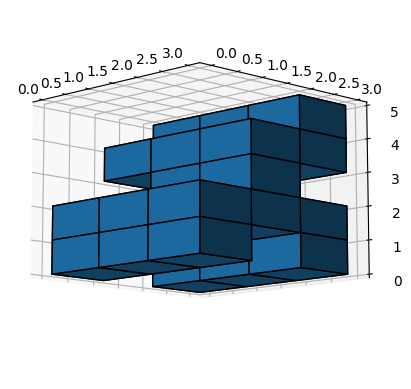

In [24]:
draw(topology)

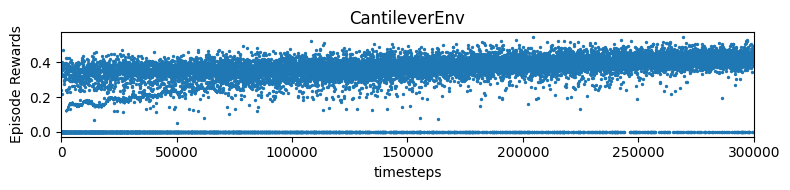

In [25]:
results_plotter.plot_results([log_dir], ts, results_plotter.X_TIMESTEPS, "CantileverEnv")

In [50]:
obs = env.reset()

In [51]:
obs = obs[0]

In [52]:
model_best = PPO.load(log_dir + "best_model.zip", env = env)

In [53]:
i=0
ans=[]
while i<1000:
    action, _states = model_best.predict(obs)
    obs, rewards, dones, _ , info = env.step(action)
    ans.append(obs)
    if dones:
        break
    
    i+=1

In [54]:
topology = reconstruct_3d_structure(ans[-1]['X_projection'].astype(np.uint8).reshape(x0,y0), 
                                    ans[-1]['Y_projection'].astype(np.uint8).reshape(y0,z0),
                                    ans[-1]['Z_projection'].astype(np.uint8).reshape(x0,z0))

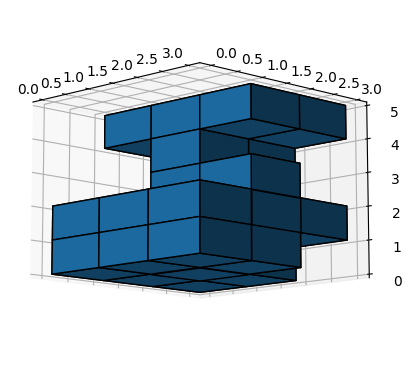

In [55]:
draw(topology)